$$ {\huge Data \quad kompresjon \quad med \quad Fourier \quad analyse} $$

$ \textbf {Introduksjon:} $

I denne compiutional essay skal vi konsentrere på audio kompresjons ved hjelp av Furier analyse. Vi skal sammenlikne forskjellige fremgangsmåter som for eksempel STFT i motsetning til FFT av hele fil, effekt av hanningvindu. Målet er å avgjøre mulig kompresjons, med akseptable kvalitets degradering. Dessverre er dette et subjektiv begrep, og resultatet skal derved være kun orienterende.

I prosessen blir vi nød til å avgjøre den beste fremgangsmåten, eller bli beviste på forskjeller mellom dem, dersom vi ikke finner en overordnende metode. For å sammenlikne kvalitet av metoder, skal vi benytte både subjektiv tanke og en matematisk fremgang basert på minste kvadrat. Det er viktig å bemerke at vi kun er interessert i kompresjon ved hjelp av Furier analyse.

Merk at resultatene er veldig avhengig av type lydfil vi skal jobbe med. Skulle foreksempel lyden være en ren sinus signal med frekvensen gitt som $ \omega_1 \cdot k \quad k \in \mathbb{N} $ der $ \omega_1 $ er grunn frekvens, kan lyden lageres ved hjelp av to tall, frekvens og amplitude. Derimot for en kaotisk lyd med frekvenser over hele spekteret blir resultater veldig limitert.

$ \textbf {Bakgrunn:} $

Alle data kompresjons metoder kan deles inni to kategorier, lossy og lossless. Lossless metoder har ingen effekt på kvalitet, mens lossy degraderer data. Selvfølgelig ønsker vi minimale kvalitets endringer, men maksimale kompresjons emne. En mulig fremgangsmåte er Furier analyse. Metoden baserer seg på å ignorere visse frekvenser av signalet. Bemerk at metoden er ikke begrenset til bruk i lyd signaler, blant annet kan den benyttes til kompresjon av bilder.

Dersom vi ønsker å lage en lossy kompresjons metode, er spørsmålet hvordan kan vi mynke data mengden mens vi senker data kvalitet. Dette er ikke så primitivt som det høres initielt ut som. Vi kan gjøre noen primitive endringer, som for eksempel senke samplings raten, eller senke bit systemet, men FT tilbyr en interessant fremgang. I stedet for å lagere og filtrere data i tids domene, velger vi å transformere signalet til frekvens domene. Vi kan deretter sortere individuelle frekvenser som original signalet består av for å mynke plass som trenges for å lagere signalet. Et åpenbær fordel av å filtrere frekvens domene, i stedet for tids domene, er at vi beholder analogien av signalet. Med andre ord, datamaskiner arbeider med binære integere, og dersom vi skal mynke størelsen av data rett inni tidsdomene, får slutt produktet digitale urenheter, for eksempel mer firekantet bølger. Der i mot, når vi minker data i frekvens domene, vil slutte prodkutet etter invers transformasjon fortsatt kunne være analogt bølge med høyere oppløsning, altså mindre firekantet. I stedefor beskrevet digitale spor i signalet, vil noen elementer i sluttetproduktet ha litt forskyvet faser eller amplituder i forhold til originalen.

$ \textbf {Teori:} $

Vi skal benytte den diskrete fourieranalyse og den invers:
$$ A_k = \frac{1}{N} \sum _{n=0}^{N-1} f(t_n) e^{-i \frac{2 \pi}{N} kn} \quad \quad k = - \frac{N-1}{2},\cdot \cdot \cdot,0,\cdot \cdot \cdot ,\frac{N-1}{2} $$
Der $ A_k $ er amplitude for vinkel hastighet $ \omega _k = \frac{2 \pi}{N} k $, $ f(t_n) $ er verdi i tids domene for tiden $ t_n $ og N er nummer av punkter i tids domene.

Invers er da gitt som:
$$ f(t_n) = \sum_{k=0}^{N-1} A_k e^{i \frac{2 \pi}{N} kn} $$

I praksis skal vi benytte numpys nummerisk Fast Fourier transformasjon. Denne skal jeg ikke beskrive matematisk da det dessverre ikke er pensum i FYS2130, men den baserer seg på å utnytte symetrier mellom noen funksjoner til respektive vinkelhastigheter, for å minker antall beregninger som trenges. I STFT skal vi bruke identiske metoder, men vi først fordeler tids domene i mindre biter som vi skal transformere individuelt. Ideen er at dette kunne være nyttig når sangen forandrer rytme, eller når det kommer en område uten lyd. Der imot kommer dette til å føre til limitasjon av laveste frekvens som vil da være $ \frac{1}{\Delta t} $, der $ \Delta t $ er tids vindu til hver individuell FT. Sammtidig kan dette føre til raske hopp i tids domene nær kantene av respektive tid vinduer. Dette kan vi prøve å minimalisere med hjelp av for eksempel hamming vindu, men det er sannsynlig at denne løsningen vil skape nye problemer i lydkvalitet. Oppsumert er det derfor viktig å ikke lage for korte tids vinduer.

Til slutt er det viktig å nevne at denne essay interesserer seg ikke i computation problemer som for eksempel lagering av data. Selv om det kommer komentarer angående denne problematikken, skal vi i utgangspunkte anta at array elementer lik 0 tar ingen plass.

$ \textbf {Metoder:} $

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

Essensielt, kan vi fordele alle variasjoner inni to metoder, transformasjon av signalet i sin helhet, og fordeling av signalet inni mindre segmenter. Derfor skal jeg lage to subklasser, og en superklasse der det skal opplastes og arbeidet med signalet i tidsdomene. Vi trenger ikke mer enn en konstruktør og en metode som skal plotte data i tidsrommene.

Merk at noen bit representasjone har drastisk forskjellige amplituder, men dette er urelevant for oss, da FT lagerer og rekonstruerer samme størelses orden.

Herifra skal jeg referere til FT av hele signalet som FFT, og biter om gangen som STFT.

In [3]:
class Comprime: #Superklasse med metoder FFT og STFT har tilfelles, og konstruktør
    def __init__(self,data,fs,T0,T1,t):
        self.T0 = T0 #Start tid i område av interesse [s]
        self.T1 = T1 #Slutt tid i område av interesse [s]
        self.fs = fs #Samplings frekvens [Hz]
        self.time_dom = data
        self.dt = 1/fs #Tid mellom hver målepunkt [s]
        self.N = len(self.time_dom) #Antall data punkter mellom T0 og T1 []
        self.t = t
        

        
        
    def plot_time_dom(self, t,time_dom,label): #Plotter tids domene
        plt.figure(figsize=(8,4))
        plt.plot(t,time_dom)
        plt.title(label)
        plt.xlabel('t [s]')
        plt.ylabel('Amplitude')
        plt.show()
        
        
    def filtring(self,percent=False, per_inc_phase=False,top_f=False,STFT=False): #Filtrerer ut lite relevant data for å oppnå kompresjon
        if type(STFT) == np.ndarray: #Formalitet som sikrer at koden virker dersom instansen er fra STFT subklasse
            self.freq_dom = STFT
            
        indexes = np.array([])
            
        if top_f != False: #Filtrerer ut alle frekvensene høyere enn top_f[Hz]
            indexes = np.where(abs(self.freq_axis)>top_f) #Finner indekser som vi må fjerne fra data array
        for index in indexes:
            self.freq_dom[index] = 0 #Filtrerer ut data
            
        
        if percent != False: #Filtrerer ut percent% av laveste tall verdi av amplituder
            sort = np.sort(abs(self.freq_dom)) #Sorterer alle amplituder fra laveste til største
            element_bound = int(self.N*percent/100) #Finner element til høyeste verdi vi vil se bort i fra (i sort array)
            value_bound = abs(sort[element_bound]) #Finner høyeste verdi vil vil se bort ifra
            indexes = np.where(abs(self.freq_dom) < value_bound)[0] #Finner indekser til verdiene vi vil se bort i fra
        for index in indexes:
            self.freq_dom[index] = 0 #Filtrerer ut data
        
        
        if per_inc_phase != False: #Filtrerer ut per_inc_phase% av laveste amplituder til individuelle cos og sin
            real = np.real(self.freq_dom) #Separerer real del (cosinus amplituder)
            imag = np.imag(self.freq_dom) #Separerer imaginær del (sinus amplituder)
            all_amps = abs(np.append(real,imag)) #Setter de sammen inni en liste for å sortere
            sort = np.sort(all_amps) #Sorterer fra lavest til høyest
            element_bound = int(2*self.N*per_inc_phase/100) #Finner element til høyeste verdi vi vil se bort i fra (i sort array)
            value_bound = sort[element_bound] #Finner høyeste verdi vil vil se bort ifra
            
            r_indexes = np.where(abs(real)<value_bound)[0] #Finner indekser til real verdiene vi vil se bort i fra
            for index in r_indexes:
                real[index] = 0 #Filtrerer ut lave real elementer (cosinus amplituder)
            i_indexes = np.where(abs(imag)<value_bound)[0] #Finner indekser til imaginære verdier vi vil se bort i fra
            for inedx in i_indexes:
                imag[index] = 0 #Filtrerer ut lave imaginære elementer (sinus amplituder)
                
            self.freq_dom = real + 1j*imag #Kombinerer de to filtrerte arrays til en ny

Det mest interessant her er filtrerings funksjon. Vi har tre måter å filtrere data på:


#### 1. Filtrere vekk alle bidrag høyere enn en vis frekvens. Det er 2 spørsmål som jeg lurte på når jeg vurderte denne måten:
    Hvordor ikke også filtrere veldig lave frekvenser?
Fundamental frekvens til menneske stemme ligger mellom 80Hz og 300Hz, mens med samlingsrate på over 40kHz følge Nyquist teoremet inkluderer vi frekvenser på over 20kHz. Dette kan man fint se i frekvens domene graf. Derved er det mye mer å tjene på å fjerne de høye frekvensene og siden dette kun er en demonstrasjon av prinsipp, inkluderer vi ikke filtasjon av lave frekvenser.


    Er ikke dette det samme som å fjerne hver i-te element fra tids domene?
Dette likner litt på å fjerne hver i-te element fra tidsdomene, men det er to hovedforskjeller. (i) Vi effektivt fjerner bidrag av disse frekvensene. (ii) Vi kan rekonstruere tids domene med samme, eller enda høyere samlingsrate. Det kan virke unødvendig å beholde samelings rate, eller øke det, da menneske øre ikke klarer å skille på dem, når vi ikke trenger det for frekvens spekteret. Men vi må huske på at siden vi prøver å transformere en digital signal til en analog, vil høyere samplingsrate føre til en bedre representasjon av analog signalet, og høyttalere skal i teorien derfor lage finere lyd. Dette er grunnen til at det eksisterer 96kHz og til og med 192kHz samplingsrater.

Siden vi fjerner alle verdier fr den største til en gitt, kan vi fjerne dem fra listen og lagere den sammen med lengden av lyden. Derved, når vi skal rekonstruere signalet, kan vi finne grunn frekvens og derifra alle overfrekvenser.

#### 2. Filtrere en vis prosent av frekvenser med minst amplitude:
Denne måten er kanskje den mest intuitive, men den fører til en computation dilema. 
Dersom vi kun forandrer noen verdier til 0, som befinner seg mellom andre som ikke er nul, hvordan skal vi oppnå kompresjon?
Dette kommer selvfølgelig litt an på hvordan vi lagerer verdiene, men i hovedprinsippet, skal en element 0, ta samme plass inni en liste som en ikke null element. Vi kan ikke fjerne dem, siden vi hadde forskyvet alle verdiene over den. Dette spørsmålet skal jeg ikke å svare på, og jeg kommer til å anta at en 0 i listen tar ingen plass.

#### 3. Filtrere en vis prosent av svakeste amplituder inkludert ved selve frekvensene:
Forskjell mellom 2. og 3., er at i 2. oppfatter vi amplitude absolutt verdi av det komplekse tallet som representerer amplitude. Der imot i 3., oppfatter vi som amplituder også individuelle komponenter av dette komplekse tallet. I praksis vil derfor filtrasjon 2. føre kun til eliminasjon av noen frekvenser fra signaler, mens 3. kommer også til å fjerne noen faser fra frekvensene dersom de er små. Siden vi representerer faser som en kombinasjon av sin og cos funksjon med samme frekvens men forskjellig fase, får vi ved denne metoden derved fjerne alle små faserskift i nærheten av $ 0 \quad \frac{\pi}{2} \quad \pi \quad \frac{3 \pi}{4} $ radianer, da vi kan beholde bare en av de to trigeometriske funksjoner, og den kan ha en negativ amplitude.


Det er også verdt å nevne, at vi trenger selvfølgelig ikke å lagere amplituder til negative frekvenser, da de er konjugat symetriske om y aksen. Derved kan vi se burt fra dem da vi ikke mister noe informasjon.


Det er også viktig å nevne at koden tar ikke hensyn til verdiene som allerede er filtrert ut når vi benytter flere filtrasjons måter. Med andre ord, dersom vi for eksempel filtrerer ut alle frekvensene høyere enn 10[kHz] altså vi filtrerer ut mer enn halvparten, og deretter filtrerer ut 50% av minste absolutt veri av frekvenser, gjør prosent filtrering ingenting, da den filtrerer først ut alt data filtrert ut av top frekvens.

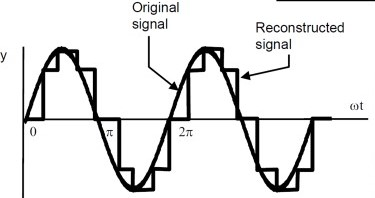

Bildet fra:
https://www.sciencedirect.com/topics/engineering/digital-to-analog-conversion

Nå skal vi skrive en subklasse der vi skal Furier transformere datafil som en helhet. Her trenger vi 3 metoder. 
1.	Transformere tidsdomene til frekvens domene.
2.	Plotte tidsdomene.
4.	Invers transformere frekvens domene.

In [4]:
class FFT(Comprime): #Sub klasse for transformasjon av signal som en helhet
    def transform_F(self): #Transformerer fra tids til frekvens domene
        self.freq_dom = np.fft.fft(self.time_dom) #Frekvens domene
        self.freq_axis = np.fft.fftfreq(self.N, self.dt) #Frekvens domene akse

    def plot_frq_dom(self,limit,label): #Plotter frekvens domene
        plt.figure(figsize=(8,6))
        plt.title(label)
        plt.xlim(0,limit)
        plt.scatter(self.freq_axis,abs(self.freq_dom), marker='.')
        plt.xlabel('f [Hz]')
        plt.ylabel('F')
        plt.show()
            
            
    def inverseF(self): #Invers transformerer filtrert frekvens domene til frekvens domene
        ift_com = np.fft.ifft(self.freq_dom)
        ift_real = ift_com.real + np.sqrt(abs(ift_com.imag**2))
        return ift_real

Funksjonen inverseF, må alle datamaskiner som skal åpne filen ha, da den skal selvfølgelig lageres i frekvensdomene. Det er også viktig å merke at denne ikke er komplett, da i utganspunkte burde vi også fjerne negative frekvenser, og disse burdde legges til data i frekvens domene, dersom vi ønsker å bruke nupys fft.ifft funksjon. Husk at negative frekvenser er symetriske til de positive om y aksen.

Nå kan vi laste opp en datafil og plotte den i tidsdommene. Jeg kommer til å velge en utvalg av sangene for å kunne sammenlikne så objektivt som mulig, da noen metoder kan virke bedre for forskjellige sanger. Når det gjelder format, bruker vi '.wav'.

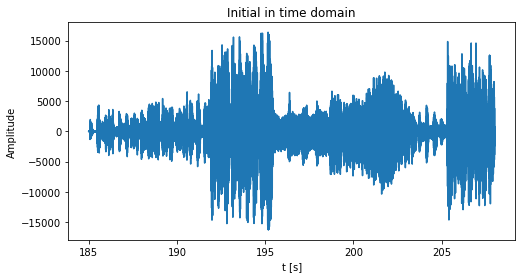

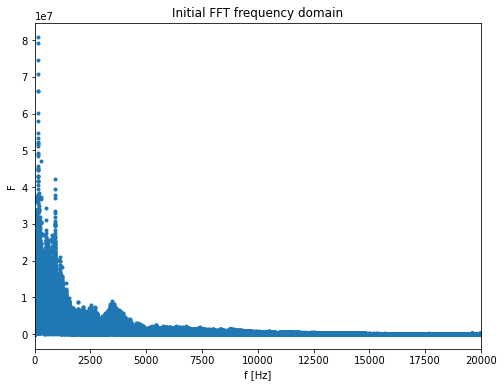

Initial state


In [5]:
fs, data = wavfile.read('Queen-BR.wav') #Laster data fil, fs er samplings frekvens [Hz] og data er tidsdomene i stereo 
data = (data[:,0]+data[:,1])/2 #Omdanner stereo til mono

T0 = 185
T1 = 208
dt = 1/fs

T0_index = int(T0/dt) #Index i data ved T0 [s]
T1_index = int(T1/dt) #Index i data ved T1 [s]
data = data[T0_index:T1_index] #Data array fra T0 til T1 []
N = len(data)
t = np.linspace(T0,T1,N) #Tider fra T0 til T1 [s]

Queen_FFT = FFT(data.copy(),fs,T0,T1,t) #Lager FFT instans
Queen_FFT.plot_time_dom(Queen_FFT.t,Queen_FFT.time_dom,'Initial in time domain') #Plotter original data i tidsdomene
Queen_FFT.transform_F() #Transformerer til tidsdomene
Queen_FFT.plot_frq_dom(limit=20000, label='Initial FFT frequency domain') #Transformerer til tidsdomene

import IPython
print('Initial state')
IPython.display.Audio(data=Queen_FFT.time_dom,rate=fs) #Spiller den inverterte filen

Som forventet har frekvenser høye frekvenser veldig liten amplitude.

Vår opprinnelige signal er i stereo. Det hadde ikke vært noe problem å gjøre prosessen for begge kanaler separat, men det kommer til å være lettere å arbeide med mono signal. Denne får vi ved å gjennomsnitt kombinere begge kanalene.

Da gjenstår det å skrive andre subklasse for Short-time Fourier transformasjon. Jeg skriver mitt egen transformasjon kode i stedet for å bruke for eksempel scipy.signal.stft, da jeg ønsker full kontroll over transformasjon for å kunne invers effektivt invers konvertere. For filtrering skal vi benytte filtrasjons metode fra superklassen.

In [6]:
from scipy.signal import windows as win #Vi skal benytte to typer vinduer hamming og tukey, som vi importerer

class STFT(Comprime): #STFT subklasse
    def ST_transform(self,t_window,stft_win=False): #Transformerer fra tids domene til STFT
        DT = self.T1-self.T0 #Total varighet av signalet i [s]
        self.points_ST = int(DT/t_window) #Antall transformasjoner
        points_per_FT = int(self.fs*DT/self.points_ST) #Antall data punkter per transformasjon
        
        self.Z = [] #List for frekvens domene verdier
        self.t_st = [0] #List for tidsverdier til transformasjoner. 0 er en formalitet som blir fjernet på slutten
        index0 = 0 #Start indeks i tidsdomene
        self.freq_axis = -np.fft.fftfreq(points_per_FT, self.dt) #Frekvens akse til frekvens domene
        self.N = len(self.freq_axis) #Lagrer antall punkter per FT. Denne kan også finnes fra points_ST
        
        windows = {'ham':win.hamming,'tuk':win.tukey,False:np.ones} #Vinduer vi kan prøve
        window = windows[stft_win](self.N) #Velger vindu


        for i in range(self.points_ST):
            index1 = index0 + points_per_FT #Slutt indeks i tidsdomene
            tmp_time_dom = self.time_dom[index0:index1] #Slicer bit av tids domene vi skal transformere
            tmp_time_dom *= window #Multipliserer med vindu vi valgte
            self.Z.append(np.fft.fft(tmp_time_dom)) #Lagerer frekvens domene
            index0 += points_per_FT #Nytt starte indeks
            self.t_st.append(t_window+self.t_st[-1]) #Lagerer nytt tid for denne transformasjonen
        
        self.Z = np.array(self.Z).T #Formalitet for å kunne plotte
        self.t_st = np.delete(np.array(self.t_st),0) #Fjerner initial verid 0
        
        
    def plot_STFT(self,limit,label): #Plotter STFT
        plt.figure(figsize=(16,4))
        plt.title(label)
        plt.ylim(0,limit)
        plt.pcolormesh(self.t_st, self.freq_axis, abs(self.Z),shading='gouraud')
        plt.title('STFT')
        plt.xlabel('t [s]')
        plt.ylabel('f [Hz]')
        plt.colorbar()
        plt.show()
    
    
    def STFT_filter(self,percent=False, per_inc_phase=False,top_f=False): #Sender frekvens domene for filtrasjon
        self.Z = self.Z.T #Formalitet for å gjøre indeksering lettere. Vil bli fjernet på slutten
        for i in range(self.points_ST):
            self.filtring(percent,per_inc_phase,top_f,STFT=self.Z[i]) #Sender inn for filtrasjon i Superklasse
            self.Z[i] = self.freq_dom #Lagerer filtrert data
        self.Z = self.Z.T #Returnerer frekvens domene til original form
        
    
    def inverse_ST(self): #Invers transformerer filtrert data
        ST_inv = np.zeros(0) #Lager en tom numpy nd.array
        for i in range(self.points_ST):
            st_inv_temp = np.fft.ifft(self.Z[:,i]) #Invers transformerer
            st_tmp = st_inv_temp.real + st_inv_temp.imag #Kombinerer begge bydrag i tidsdomene
            ST_inv = np.append(ST_inv,st_tmp) #Appender til listen av hele tids domene
        
        if len(self.t) != len(ST_inv): #Sikkrer at tider og tids domene har samme lengde, ST_transform kan kutte av slutt
            indexes = -np.arange(1,int(len(self.t)-len(ST_inv)+1)) #Indekser til overs, fra toppen
            self.t = np.delete(self.t,indexes) #Fjerner fra tidene
        
        return ST_inv

#### Her har ve endt opp med å skrive 4 metoder:

1. Første transformerer tids domene til frekvens domene av STFT. Metoden tar inn to argumenter. (i) t_window som angir tiden per transformasjon. Legg merket til at når t_window ikke er et heltalls multiplet av den totale lengden, er det ikke mulig å fordele alt data inni riktig størrelses bins. Dette kan vi enten gjøre ved å stille på tids vindu eller data. Denne metoden konserverer tid vindu og kutter av siste bit som ikke er langt nok. Merk at vi må uansett avrunde tids vindu, da vi er begrenset til å jobbe mellom heltalls indekser. Det hadde kanskje vært bedre om vi også transformerte siste bit med en annet vindu, men dette hadde ført til problemer med plotting og siden dette bare er en demonstrasjon, så ser vi bare bort fra siste bit. Dette er ikke stor problem for små tids vinduer, men er signifikant for store tidvinduer.

2. Andre metode plotter STFT signalet.

3. Tredje metode filtrerer data, og selv om den gjenbruker filtrerings funksjon i Comprime, pga. STFT, må vi sende data inn i biter, som vi selvfølgelig gjør fra en for loop.

4. Denne metoden invers transformerer frekvensdomener, som vi identisk som i 3. må selvfølgelig gjøre i biter. Til slutt må vi for grunner nevnt i 1. sikkre oss at tids array og tidsdomene har samme lengde.

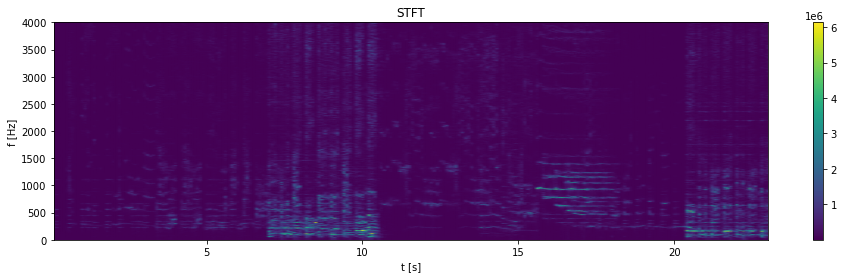

In [7]:
Queen_STFT = STFT(data.copy(),fs,T0,T1,t) #lager STFT instans
Queen_STFT.ST_transform(t_window=0.1,stft_win=False) #Short time transformerer
Queen_STFT.plot_STFT(limit=4000,label='Before filterin, Top at 3[kHz]') #Ploter STFT kuttet

Gjennom hele oppgaven skal vi bruke tids vindu på 0.1 s, da det etter testing virker optimalt.

Nå gjennstår det å filtrere ut data. Først skal vi overfiltrere data med hver måte for å se hva måtene fører til i data kvalitet, og vi skal bruke compare metoden for å avgjøre kvalitet. Deretter skal jeg subjektivt prøve å finne ideel kombinasjon av alle filtrerings metoder og vi skal prøve å sammenlikne FFT og STFT, reflektere over kvalitet og avgjøre hvor mye vi klarte å minke data mengde.

Først starter vi med å utforske tids domene vinduer til STFT, vi starter med hamming vindu:
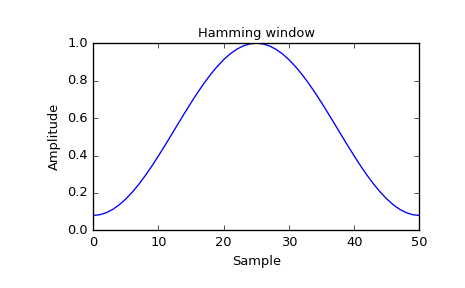

In [8]:
Queen_STFT_ham = STFT(data.copy(),fs,T0,T1,t) #lager STFT instans
Queen_STFT_ham.ST_transform(t_window=0.1,stft_win='ham') #Short time transformerer med hammings vindu
st_con_ham = Queen_STFT_ham.inverse_ST() #Inverterer

print('STFT per 0.1[s] with hamming window')
#IPython.display.Audio(st_con_ham,rate=fs) #Spiller den inverterte filen

STFT per 0.1[s] with hamming window


Dette høres selvfølgelig uakseptabelt ut og det var ikke uforventet. Det er et vindu til vi kan bruke, som sannsynlighvis kommer til å høres bedre ut, da den har en konstant område, nemlig tukey vindu:
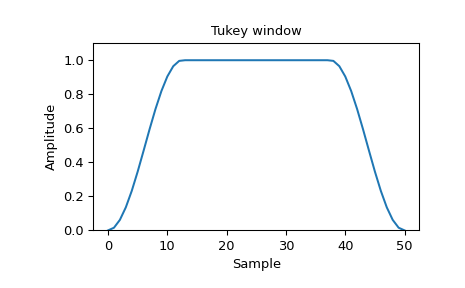

In [11]:
Queen_STFT_tuk = STFT(data.copy(),fs,T0,T1,t) #lager STFT instans
Queen_STFT_tuk.ST_transform(t_window=1,stft_win='tuk') #Short time transformerer med tukey vindu
st_con_tuk = Queen_STFT_tuk.inverse_ST() #Inverterer

print('STFT per 0.1[s] with tukey window')
#IPython.display.Audio(st_con_tuk,rate=fs) #Spiller den inverterte filen

STFT per 0.1[s] with tukey window


Dette er litt bedre, men langt i fra akseptabelt musikk. Vi er derved nød til å konkludere at vi ikke kan benyte oss av vinduer i dette prosjektet, og alle STFT transformasjoner fra nå av skal ha stft_win set til False, som er ekvivlent med ingen vindu.

Nå er det på tide å skrive en sammenliknings funksjon. Denne skal som sakt basere seg på lineær algebra, og score den vil returnere blir avstanden mellom vektor av original data og vektor av filtrert data. Med andre ord, lavere score er bedre. Altså:
$$ score = | \vec{old} - \vec{new}| = \sqrt{(\vec{old} - \vec{new}) \cdot (\vec{old} - \vec{new})} = \sqrt{\sum_{i=1}^{N} (old_i-new_i)^2} $$
Der old er original tids domene, new er filtrert tids domene og N er antall målepunkter.

In [12]:
def compare(old,new): #Score funksjon basert på minste kvadrat
    if len(old) != len(new): #Sikkrer at begge arrays har samme lengde, ST_transform kan kutte slutten vekk
        indexes = -np.arange(1,int(len(old)-len(new)+1)) #Indekser til overs, fra toppen
        old = np.delete(old,indexes) #Fjerner verider til overs fra original data
            
    D_l = old - new #Finner vektor fra gammel til ny (data i frekvens domene) 
    score = np.linalg.norm(D_l) #Bestemmer lengden til denne vektoren (avstanden mellom old og new)
    return score

Nå skal vi begynne å filtrere ut data. Vi skal nå filtrere ut 10% av alt data, ved hjelp av de tre filtrasjons metoder. Vi lager to filer for hver filtrasjon metode, der første skal være for FFT og andre for STFT. Først starter vi med å begrense maksimal frekvens til 0.1*samplerate/2, slikt at vi beholder 10% av data (legg merket til at maksimal frekvens i vår analyse er i følge Nyquist fs/2, derved er 0.1*fs/2 10% av denne frekvensen):

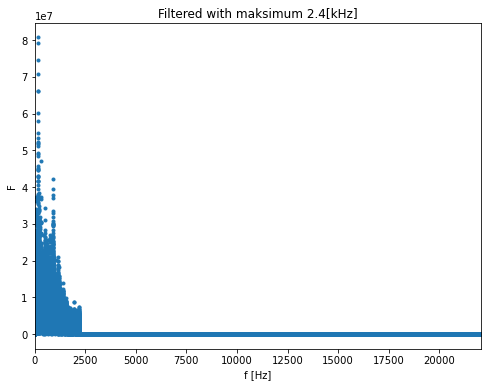

In [13]:
Queen_FFT.filtring(percent=False,per_inc_phase=False,top_f=0.1*fs/2)
Queen_FFT.plot_frq_dom(limit=fs/2,label='Filtered with maksimum 2.4[kHz]')

Queen_STFT.STFT_filter(percent=False, per_inc_phase=False,top_f=0.1*fs/2)

Som vi kan se gjør koden det vi ønsker, og den har kuttet ut alle frekvensene høyere enn 0.1*fs/2=48kHz/2*0.1=2.4kHz. Vi plotter ikke STFT for to grunner: (i) Det var ikke mulig å se komponenter høyere enn 2.4kHz da vi plottet den, (ii) denne prossesen er krevende for minne og vi er limitert til 1.5GB.

In [15]:
FFT_2400hz = Queen_FFT.inverseF()

print('FFT limited to 2.4kHz')
print(f'score = {round(compare(data,FFT_2400hz))}')
#IPython.display.Audio(data=FFT_2400hz,rate=fs)

FFT limited to 2.4kHz
score = 717762


In [16]:
Queen_STFT.STFT_filter(top_f=2400)
STFT_2400hz = Queen_STFT.inverse_ST()

print('STFT limited to 2.4kHz')
print(f'score = {round(compare(data,STFT_2400hz))}')
#IPython.display.Audio(data=STFT_2400hz,rate=fs)

STFT limited to 2.4kHz
score = 719355


Her kan vi fint høre i STFT måten, hører vi tik per 0.1 s. Dette  skyldes grense mellom hver transformasjon, der en slutter på et annet punkt enn den andre begynner. Dette er nemlig grunnen vi vurderte bruk av vinduer. Her er det FFT som høres bedre ut, og den får også bedre (lavere) score, altså den er nærmere original data. FFT vinner definitivt her.

Selve måten å kompresse data på virker. Denne måten var kanskje ikke overraskende og vi viste hva som kommer til å skje, men neste måten, der vi skal eliminere 90% av frekvensene med minst bidrag er mer vanskelig å forutsi. Vi skal igjen beolhde 10% av original data.

In [18]:
Queen_FFT_90per = FFT(data.copy(),fs,T0,T1,t)
Queen_FFT_90per.transform_F()
Queen_FFT_90per.filtring(percent=90)
FFT_90per = Queen_FFT_90per.inverseF()

print('FFT with 10% of original frequencis')
print(f'score = {round(compare(data,FFT_90per))}')
#IPython.display.Audio(data=FFT_90per,rate=fs)

FFT with 10% of original frequencis
score = 512553


In [19]:
Queen_STFT_90per = STFT(data.copy(),fs,T0,T1,t)
Queen_STFT_90per.ST_transform(t_window=0.1,stft_win=False)
Queen_STFT_90per.STFT_filter(percent=90)
STFT_90per = Queen_STFT_90per.inverse_ST()

print('STFT with 10% of original frequencis')
print(f'score = {round(compare(data,STFT_90per))}')
#IPython.display.Audio(data=STFT_90per,rate=fs)

STFT with 10% of original frequencis
score = 390725


Nå kvaliteter til de to FFT of STFT endelig åpenbart tydelig. Ved å beholde kun 10% av de frekvensene med størst amplitude, får FFT en ubehagelig støy. Dette skjer ikke med STFT måten, da den er mye renere. Den får derimot har den fortsatt en klikk per tids vindu, som skyldes overganget. Her er det fint å forandre på t_window variabel, da kortere tids vindu fører til enda renere lyd, men flere klikk, derimot kortere tidsvinduer fører til færre klikk, men mer bakgrunn støy.

I følge score, er STFT bedre aproksimasjon enn FFT og dette er ikke rart, etter å ha hørt på lyden. Men i praksis er det ikke så lett å estimere, da klikke lyden er veldig forstyrrende. Uansett er begge tilfellene bedre tilnærming enn første måte i følge score. Dette synes jeg også er sant når det kommer på subjektiv oppfattning av lyd.

I siste måten, skal vi fjerne 90% av de laveste amplituder til selve trigeometriske funskjoner, derved kan dette i motsetning til de to andre måter fjerne lave faser, som beskrevet ovenfor.

In [20]:
Queen_FFT_90pha = FFT(data.copy(),fs,T0,T1,t)
Queen_FFT_90pha.transform_F()
Queen_FFT_90pha.filtring(per_inc_phase=90)
FFT_90pha = Queen_FFT_90pha.inverseF()

print('FFT with 10% of original trigeometric functions')
print(f'score = {round(compare(data,FFT_90pha))}')
#IPython.display.Audio(data=FFT_90pha,rate=fs)

FFT with 10% of original trigeometric functions
score = 293132


In [21]:
Queen_STFT_90pha = STFT(data.copy(),fs,T0,T1,t)
Queen_STFT_90pha.ST_transform(t_window=0.1,stft_win=False)
Queen_STFT_90pha.STFT_filter(per_inc_phase=90)
STFT_90pha = Queen_STFT_90pha.inverse_ST()

print('STFT with 10% of original trigeometric functions')
print(f'score = {round(compare(data,STFT_90pha))}')
#IPython.display.Audio(data=STFT_90pha,rate=fs)

STFT with 10% of original trigeometric functions
score = 240648


Denne metoden er i føge score den beste av de tre, men subjektivt tror jeg at metode nr.2 høres bedre ut for FFT, da bakgrunnen i nr.2 høres ut som grå lyd, altså konsistent støy. Derimot metode nr.3 har renere lyd men bakgrunn støy er inkonsistent og det høres ut som om noen veldig nær mikrofonen under opptak.

Der imot virker metode nr.3 mye bedre for STFT enn nr.2 gjorde. Siden vinduer har 0.1s virker ellers inkonsistent støy, konsistent. Denne måten klarer til å med å mynke overgangs klikk i STFT.

Derved konkluderer vi med at for FFT er det best å filtrere ut frekvensene med lavest amplitude, mens med STFT er det best å filtrere ut amplituder til selve sinus og cosinus elementer. Det er også viktig å nevne at tids vindu for STFT er også veldig viktig.

Nå gjennstår det bare to ting. (i) Finne et optimalt filtrering. (ii) Finen hvor mange tall eksludert null, trenger vi for å lagere en slikt fil, i forhold til å lagere tids domene.









Vi starter først med å skrive kode som finner faktor av ikke nuller i fre

In [22]:
Queen_FFT_55per = FFT(data.copy(),fs,T0,T1,t)
Queen_FFT_55per.transform_F()
Queen_FFT_55per.filtring(percent=55)
FFT_55per = Queen_FFT_55per.inverseF()

print('FFT with 45% of original frequencis')
print(f'score = {round(compare(data,FFT_55per))}')
#IPython.display.Audio(data=FFT_55per,rate=fs)

FFT with 45% of original frequencis
score = 59043


In [23]:
Queen_STFT_80pha = STFT(data.copy(),fs,T0,T1,t)
Queen_STFT_80pha.ST_transform(t_window=0.1,stft_win=False)
Queen_STFT_80pha.STFT_filter(per_inc_phase=80)
STFT_80pha = Queen_STFT_80pha.inverse_ST()

print('STFT with 20% of original trigeometric functions')
print(f'score = {round(compare(data,STFT_80pha))}')
#IPython.display.Audio(data=STFT_80pha,rate=fs)

STFT with 20% of original trigeometric functions
score = 139156


Jeg konkluderer med at 80% i STFT måte nr.3 og 55% i FFT måte nr.2 er av akseptabelt kvalitet. Legg merket at disse er vannskelig å sammenlikne disse to, da hver av dem fører til anderledes type støy. Samtidig er det interessant at STFT har score på 139156 og FFT på 59043.

Da gjennstår det kun å beregne hvor mye minne vi klarte å kompresse filen. Husk at vi skal slette alle negative frekvenser, da disse som beskrevet overnfor er disse symetriske om y aksen.

In [24]:
N_original = len(data) #Antall punkter i tids domene

#For FFT:
FFT_frq = Queen_FFT_55per.freq_dom #Frekvens domene
indexes = np.where(Queen_FFT_55per.freq_axis < 0)[0] #Finner indekser der frekvenser er negative
FFT_frq = np.delete(FFT_frq,indexes) #Sletter amplituder til negative frekvenser
N_FFT = 2*len(np.where(FFT_frq != 0)[0]) #Finner antall punkter som ikke er null. 2 faktor pga. tall er komplekse

#For STFT:
STFT_frq = Queen_STFT_80pha.Z
indexes = np.where(Queen_STFT_80pha.freq_axis < 0)
values = []
for col in STFT_frq.T:
    values.append(np.delete(col,indexes))
values = np.array(values)
real = np.real(values)
imag = np.imag(values)
N_STFT = len(np.where(real != 0)[0])
N_STFT +=  len(np.where(imag != 0)[0])

print(f'FFT har {N_original/N_FFT:.3f} ganger færre ikke null elementer')
print(f'STFT har {N_original/N_STFT:.3f} ganger færre ikke null elementer')

FFT har 2.222 ganger færre ikke null elementer
STFT har 1.670 ganger færre ikke null elementer


Som vi ser, klarer FFT mynke data størelse mer enn STFT.

$ \textbf {Konklusjon:} $

Vi har testet ut 2 fremgangsmåter, STFT og FFT, med 3 forskjellige filtrerings måter. Vi har utforsket kvalitet på lyden de forskjellige måtene gir og prøvd å finne en optimal kompresjon. Vi har konkludert med, at dersom vi fjerner 55% av frekvensene til FFT kan vi representere original filen, ved hjelp av 2.222 gager fære tall som ikke er null enn dersom vi skulle lagere den i tids domene. I følgede dekompresjon kan man høre nedgang i kvalitet i form av støy, men den er aksepabel i denne tilfellen.